# Visualization

This notebook show how to access the content of the products downloaded in [](01a-download-process.ipynb) and plot a true-color rendering. 
While the products already contain a True-Color Image (TCI), this approach is useful for two reasons:

1. It allows comparing the readings with a rendering provided by official sources, thereby allowing us to find errors
2. Generating a custom True-Color Image can be useful for further image manipulations, changing contrast or changing out single bands for others to highlight specific phenomena.

We start by reading the shape of Berlin previously downloaded from OpenStreetMap:

<AxesSubplot:>

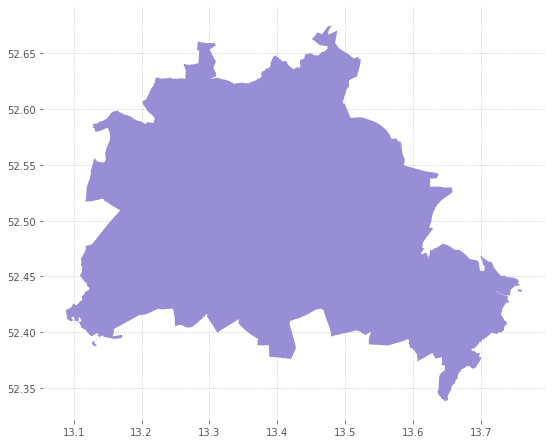

In [1]:
from pathlib import Path

import geopandas as gpd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

resources = Path('resources')
berlin = gpd.read_file(resources / 'berlin.geojson')

fig, ax = plt.subplots(figsize=(9,9))
berlin.plot(ax=ax)

We know the product with the lowest cloud cover percentage from the previous notebook.

In [2]:
raster_files = resources / 'true_color_image'
product = next(raster_files.glob('S2B_MSIL2A_20200602T100559*.zip'))
product

PosixPath('resources/true_color_image/S2B_MSIL2A_20200602T100559_N0214_R022_T33UUU_20200602T135324.zip')

The product path contains a lot of information:

- `S2B` shows that the downloaded products was captured by the Sentinel-2 satellite B. At the moment there are two satellites in the mission, A and B.
- `MSI` stands for Multi Spectral Instrument.
- `L2A` is the processing level; Level 2A is the highest processing level and mostly. Lower processing levels need further processing depending on your use-case.
- The first timestamp, `20200602T100559`, is the date at which the data was captured.
- `N0214` is the processing baseline. This is like a version string that encodes how the previous processing steps were performed.
- `R022` is the relative orbit number.
- `T33UUU` is the unique name of the area which is covered by the product.
- The second timestamp, `20200602T135324`, "is the '\<Product Discriminator\>' field, which is [...] used to distinguish between different end user products from the same datatake." ([Source](https://sentinel.esa.int/web/sentinel/user-guides/sentinel-2-msi/naming-convention))

## Previewing Downloaded Files

There is a helper that, given a resolution and the band name, returns the correct file paths for us to use with the `rasterio` library.
It contains code to deal with compressed or uncompressed products.

In [3]:
from sentinel_helpers import scihub_band_paths
??scihub_band_paths

Signature: scihub_band_paths(p, bands, resolution=None)
Source:   
def scihub_band_paths(p, bands, resolution=None):
    '''
    Given a zip file or folder at `p`, returns the paths inside p to the raster files containing
    information for the given bands. Because some bands are available in more than one
    resolution, this can be filtered by prodiding a third parameter (e.g. resolution='10m').
    
    - `p` can be a string or a pathlib.Path.
    - `bands` can be a list of bands or a single band.
   
    The returned paths are formatted in the zip scheme as per Apache Commons VFS if necessary
    and can be directly opened by rasterio.
    '''
    if type(bands) != list:
        # allow passing in a single band more easily
        bands = [bands]
    
    p = Path(p) # make sure we're dealing with a pathlib.Path
    if p.suffix == '.zip':
        # when dealing with zip files we have to read the filenames from the
        # archive first
        with ZipFile(p) as f:
            f

Using the compressed zip-file, while slightly inconvenient, makes sense because it allows saving disk space and allows us to avoid the extra step of decompressing every single downloaded product.

There is a pre-rendered True-Color Image ("TCI") that we can use to get a quick plot of the contents:

In [4]:
low_res_tci = scihub_band_paths(product, 'TCI', '60m')[0]
low_res_tci

PosixPath('zip+file:/home/jovyan/sources/resources/true_color_image/S2B_MSIL2A_20200602T100559_N0214_R022_T33UUU_20200602T135324.zip!/S2B_MSIL2A_20200602T100559_N0214_R022_T33UUU_20200602T135324.SAFE/GRANULE/L2A_T33UUU_A016922_20200602T101204/IMG_DATA/R60m/T33UUU_20200602T100559_TCI_60m.jp2')

Using the `rasterio` library we can open this image and render its contents:

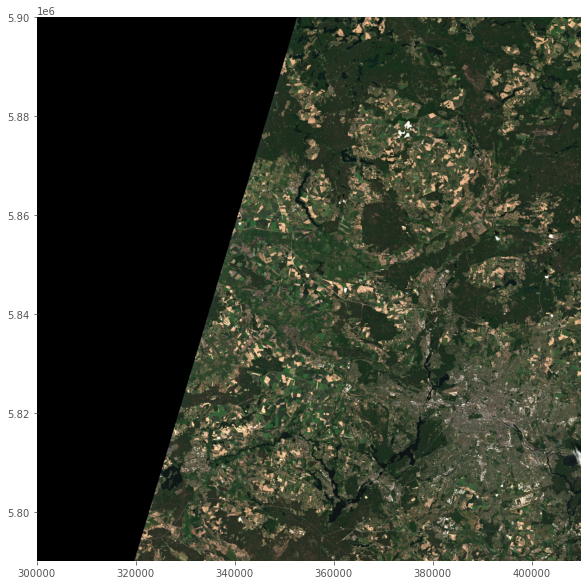

In [5]:
import rasterio as r
import rasterio.plot as rplt

with r.open(low_res_tci) as tci:
    fig, ax = plt.subplots(figsize=(10,10))
    ax.grid(False)
    rplt.show(tci)

You will see this pattern repeatedly:

``` python
with r.open(...) as src:
    # ...
```

It is used to open one or more data sets at a time and close them as soon as the execution pointer of the block has ended. This means data is only read inside the block, which is also where the processing usually takes place.

## Creating a Custom True-Color Composition

While for many use cases using the TCI can be enough, knowing how to compose True-Color Images provides additional merit as explained above.

The blue, green, and red parts of the spectrum are represented in the raster files for the bands 2, 3 and 4 respectively
`sentinel_helpers.py` contains a helper that wraps `scihub_band_paths` to retrieve those bands in a resolution of our choice:

In [6]:
from sentinel_helpers import scihub_bgr_paths
??scihub_bgr_paths

Signature: scihub_bgr_paths(product_path, resolution=None)
Source:   
def scihub_bgr_paths(product_path, resolution=None):
    '''
    A convenence function to return the paths to the blue, green and red bands
    in the downloaded product at `product_path`.
    '''
    return scihub_band_paths(product_path, ['B02', 'B03', 'B04'], resolution)
File:      ~/sources/sentinel_helpers.py
Type:      function


In [7]:
b02, b03, b04 = scihub_bgr_paths(product, '60m')
b02.name, b03.name, b04.name

('T33UUU_20200602T100559_B02_60m.jp2',
 'T33UUU_20200602T100559_B03_60m.jp2',
 'T33UUU_20200602T100559_B04_60m.jp2')

### Full Range Plot

We continue with a plot of the combination of these bands:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


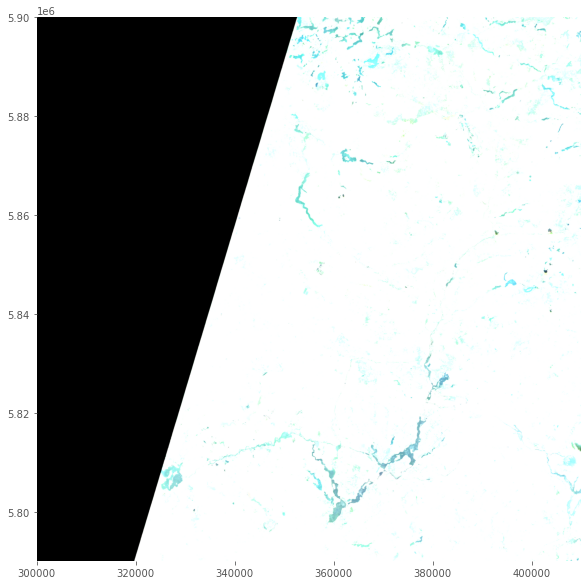

In [8]:
with r.open(b02) as blue, r.open(b03) as green, r.open(b04) as red:
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.grid(False)
    
    # calling blue.read(1) returns the first raster band of the blue raster
    # file as a numpy array. each raster file can contain multiple bands and
    # unfortunately the different parts of the spectrum are called "bands" as well.
    rplt.show([red.read(1), green.read(1), blue.read(1)],
              # we need to pass the transform explicitly if we want the plot
              # to be labelled correctly because the numpy array does not,
              # contain information about world coordinates it only uses
              # array indices
              transform=blue.transform)

What this plot shows is an effect that is akin to an overexposed photograph.
The intensity of the individual pixels seems to high, which can be verified by looking at the histogram of the data and printing a statistical summary.

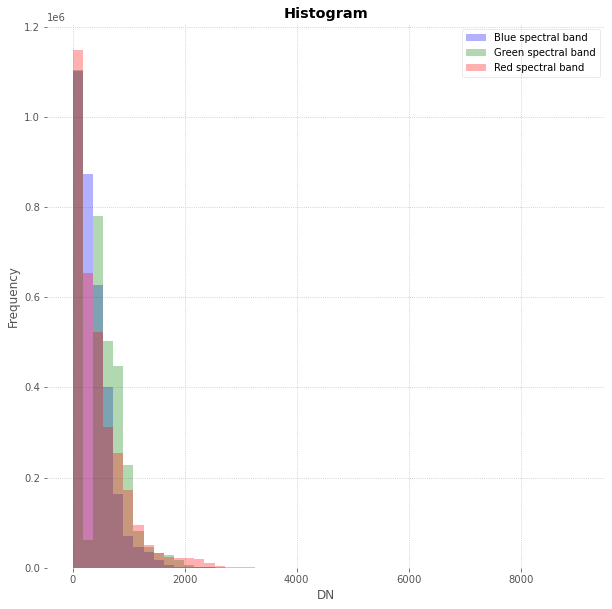

In [9]:
import numpy as np

hist_args = {
    'alpha': 0.3,
    'stacked': False,
    'histtype': 'stepfilled',
    'bins': 50
}

with r.open(b02) as blue, r.open(b03) as green, r.open(b04) as red:
    fig, ax = plt.subplots(figsize=(10, 10))
    
    rgb = np.array([red.read(1), green.read(1), blue.read(1)])
    labels = ['Red spectral band', 'Green spectral band', 'Blue spectral band']
    rplt.show_hist(rgb, label=labels, ax=ax, **hist_args)

In [10]:
for idx, band in enumerate(['red', 'green', 'blue']):
    print(f'{band} min:     {rgb[idx].min()}')
    print(f'{band} max:     {rgb[idx].max()}')
    print(f'{band} mean:    {rgb[idx].mean()}')
    print(f'{band} median:  {np.median(rgb[idx])}')
    print(f'{band} deciles: {np.percentile(rgb[idx], np.arange(0, 100, 10))}')

red min:     0
red max:     9057
red mean:    435.0680333840963
red median:  335.0
red deciles: [   0.    0.    0.    0.  271.  335.  417.  553.  751. 1022.]
green min:     0
green max:     8602
green mean:    482.2255373406193
green median:  478.0
green deciles: [  0.   0.   0.   0. 437. 478. 569. 687. 811. 971.]
blue min:     0
blue max:     8979
blue mean:    343.94775269491475
blue median:  317.0
blue deciles: [  0.   0.   0.   0. 283. 317. 370. 462. 571. 733.]


While the arrays are heavily sloped towards the lower end of the spectrum (the 90th percentile is around 1000 or lower), the range of values extends to over 9000. Contrast this with the [Sentinel User Guide](https://sentinel.esa.int/web/sentinel/user-guides/sentinel-2-msi) contains the following information the included TCI:

> The TCI is an RGB image built from the B02 (Blue), B03 (Green), and B04 (Red) Bands. The reflectances are coded between 1 and 255, 0 being reserved for 'No Data'. The saturation level of 255 digital counts correspond to a level of 3558 for L1C products or 2000 for L2A products (0.3558 and 0.2 in reflectance value respectively.

Why do the products described above extend the range of up to 2000?

The reflectance value - which is what we're usually interested in to perform arithmetic on - is a floating point number $\in [0, 1]$. The products contain digital counts (DC) or digital numbers (DN). These values have to be converted with $\frac{\text{DN}}{10\ 000}$ like the quote above implies.

The sensors on the sentinel satellite capture a lot of light outside of the spectrum visible to the human eye. The sensors are not modeled to match the sensitivity of the human eye - values which are too intense (i.e. $> 2000$) can therefore be discarded.[^other-true-color-approaches]

[^other-true-color-approaches]: Note that this is just one approach to plot an image that approximates human color perception. There are other techniques that try reconstructing human color perception in different color spaces for example.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


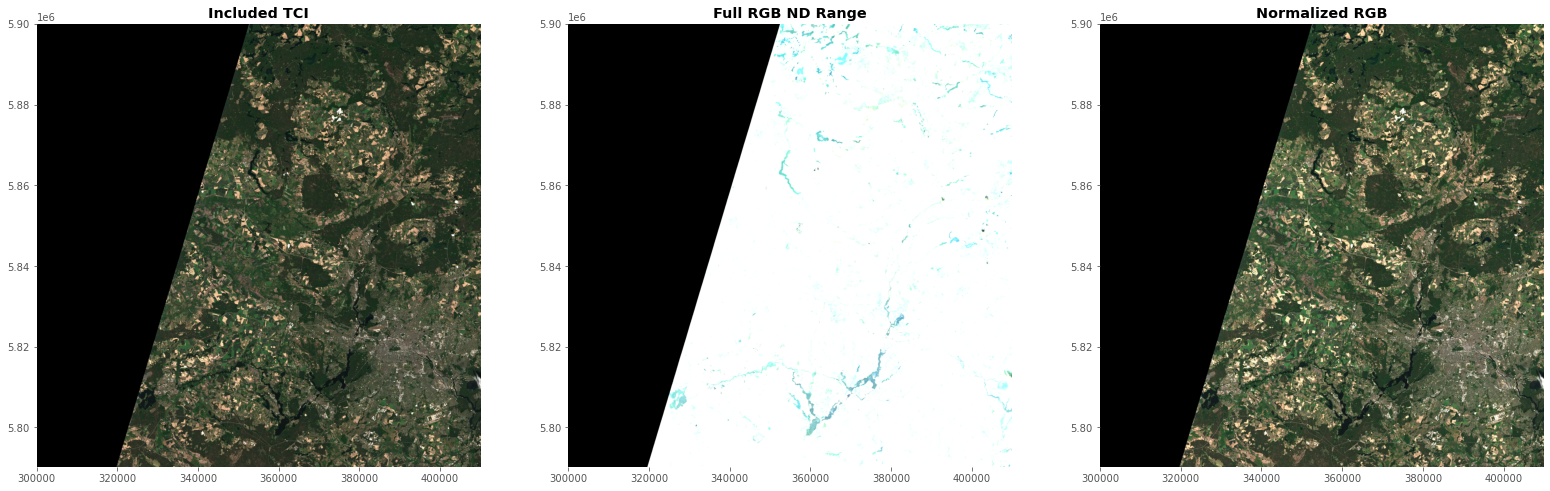

In [11]:
def normalize_rgb(rgb):
    return ((np.clip(rgb, 0, 2000) / 2000) * 255).astype(np.uint8)

with r.open(b02) as blue, r.open(b03) as green, r.open(b04) as red, r.open(low_res_tci) as tci:
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(27,9))
    ax1.grid(False)
    ax2.grid(False)
    ax3.grid(False)
    
    transform = blue.transform
    
    # included true color image
    included_tci = tci.read()
    rplt.show(included_tci, transform=transform, ax=ax1, title='Included TCI')
    
    # "overexposed" rgb image
    rplt.show(rgb, transform=transform, ax=ax2, title='Full RGB ND Range')
    
    # normalized rgb image
    normalized_rgb = normalize_rgb(rgb)
    rplt.show(normalized_rgb, transform=transform, ax=ax3, title='Normalized RGB')
    
    plt.show()
    fig.savefig(resources / 'berlin_true_color_image_naive_plot.png', dpi=300)

We can compare the histograms of `included_tci` and the `normalized_rgb` array: 

Text(0.5, 0, 'Value')

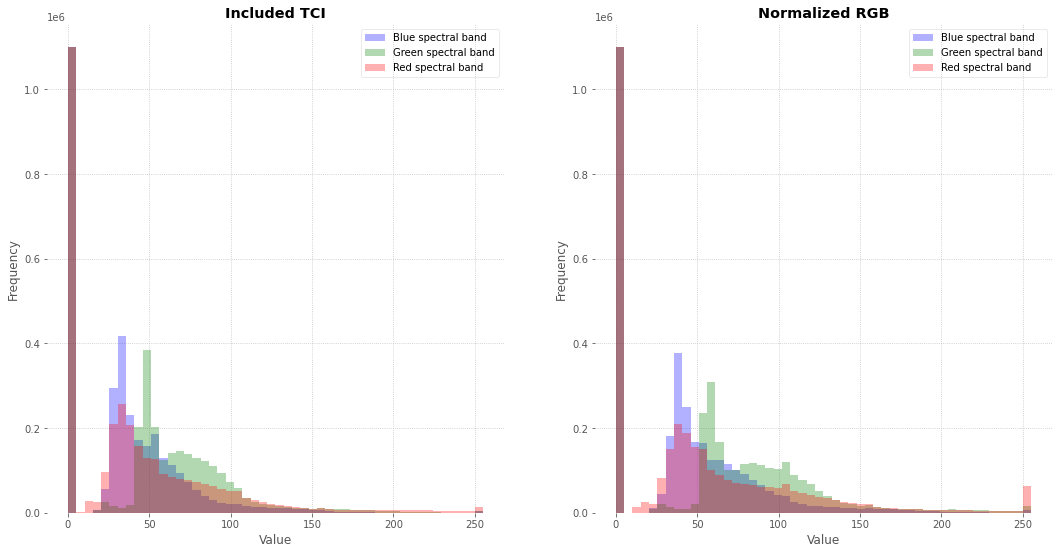

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18,9))

rplt.show_hist(included_tci, label=labels, ax=ax1, title='Included TCI', **hist_args)
rplt.show_hist(normalized_rgb, label=labels, ax=ax2, title='Normalized RGB', **hist_args)

ax1.set_xlabel('Value')
ax2.set_xlabel('Value')

We can see each the red, green and blue band peaking higher in the prerendered TCI around a value of 50 - the curves match closely. Most of the pixels are using the designated nodata-value 0, which is the black stripe in the top left corner of the image.

Because the purpose of this visualization is not creating a one-to-one replica of the included TCI but rather demonstrate how to interpret and manipulate the raster file contents, the approximation is sufficient.

### Creating a Subset of the Area of Interest

It is rare to plot the entire product because the data in this product can be partially missing depending on the orbit position (see [](01c-coverage-analysis.ipynb) for more information).

We can create a rectangular cutout of the created image using code provided in the `rasterio` library for its `rio` command line tool. The code uses a data structure called `Window`, which is a rectangle with an x- and y-offset that is provided by `rasterio` to partially read or write raster data.

The position of the `Window` is calculated by transforming the area of interest `berlin` into the Coordinate Reference System that is used by `src` and then calculating the intersection:

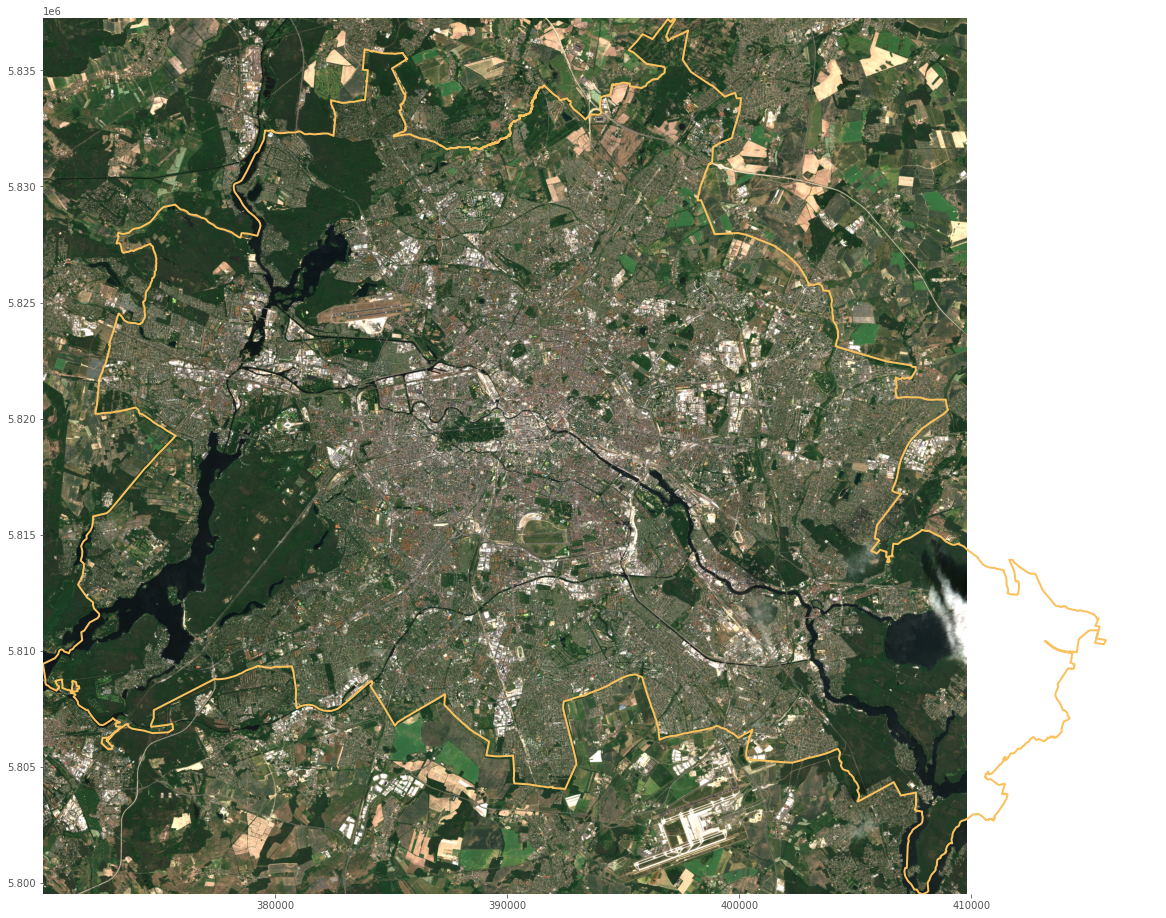

In [13]:
from tempfile import NamedTemporaryFile
from rasterio.windows import Window
from tqdm.notebook import tqdm

# use a higher resolution
b02, b03, b04 = scihub_bgr_paths(product, '10m')

# this code is based on https://github.com/mapbox/rasterio/blob/d7b2dd3ae64c55978e265fa9230732e88b1dc9ae/rasterio/rio/clip.py
with r.open(b02) as blue, r.open(b03) as green, r.open(b04) as red:
    # OpenStreetMap data uses WGS84 (i.e. latitude and longitude) for its
    # coordinate system; the coordinate system used by the product depends on
    # the UTM tile which is covered
    bounds = berlin.to_crs(blue.crs).bounds.loc[0].values
    
    # create window from the bounding box of the target area
    out_window = blue.window(*bounds).round_lengths(op='floor')
    out_window = out_window.intersection(
        Window(0, 0, blue.width, blue.height) # a window identical to `src`
    )
    
    height = int(out_window.height)
    width = int(out_window.width)
    
    # arguments for writing the slice into a new file
    out_kwargs = blue.profile.copy()
    out_kwargs.update({
        # number of combined bands
        'count': 3,
        'height': height,
        'width': width,
        
        # use the transformation matrix of the intersection (the origin changed)
        'transform': blue.window_transform(out_window),

        'driver': 'GTiff', # save as geotiff
        'dtype': np.uint8 # using integers instead of floats
    })

    # we're using a temporary file for demonstration purposes; if you want to
    # save the result somewhere else you'd probably use a `pathlib.Path`.
    with NamedTemporaryFile() as tmp:
        with r.open(tmp.name, 'w+', **out_kwargs) as out:
            src_bands = [red, green, blue]
            
            # we need to explicitly set the band which the source band is
            # written to, ranging from 1 to 3 (inclusive)
            for idx, src in tqdm(enumerate(src_bands, start=1), desc=f'Writing bands to {tmp.name}'):
                subset = normalize_rgb(src.read(
                    1,
                    window=out_window,
                    out_shape=(1, height, width)
                ))
                out.write(subset, idx)
                
            # plot the generated output
            fig, ax = plt.subplots(figsize=(20, 20))
            ax.grid(False)
            rplt.show(out.read(), transform=out_kwargs['transform'], ax=ax)
            berlin.to_crs(out_kwargs['crs']).plot(ax=ax, facecolor='none', edgecolor='#FBC15E', linewidth=2)

The plot shows that the region of interest exceeds the boundaries of a single product.
The following chapter will provide an analysis of product shapes and data availability.